In [1]:
from configparser import ConfigParser
import glob, os, cv2
from pandas import StringDtype
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from pickletools import optimize
import string
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
import time
# from draw_ellipse import *
# from ellipses import *
# from bwperim import *
os.environ["CUDA_VISIBLE_DEVICES"]='2,3'
mirrored_strategy = tf.distribute.MirroredStrategy()

BASE_TRAIN_PATH = "./new2_data_sets/train"
BASE_TRAIN_AUGMENTED_PATH = "./new2_data_sets/train_augmented"
SEED = 4444
time_start = time.time()

l_train_files = glob.glob(f'{BASE_TRAIN_PATH}/*orig.png')
l_mask_files = glob.glob(f'{BASE_TRAIN_PATH}/*mask.png')
l_train_aug_files = glob.glob(f'{BASE_TRAIN_AUGMENTED_PATH}/*orig.png')
l_mask_aug_files = glob.glob(f'{BASE_TRAIN_AUGMENTED_PATH}/*mask.png')

img_trains = np.stack([cv2.imread(i,0) for i in l_train_files])
mask_trains = np.stack([cv2.imread(i,0) for i in l_mask_files])
img_trains_aug = np.stack([cv2.imread(i,0) for i in l_train_aug_files])
mask_trains_aug = np.stack([cv2.imread(i,0) for i in l_mask_aug_files])
                
imgs = np.concatenate([img_trains, img_trains_aug], axis=0)
masks = np.concatenate([mask_trains, mask_trains_aug], axis=0)

imgs = imgs / 255.
masks = masks / 255.



print('train_shape:', imgs.shape)
if imgs.shape != masks.shape:
    print('wrong train and mask shape')
    
time_end = time.time()
print("loading times :", time_end - time_start)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
train_shape: (8640, 240, 320)
loading times : 418.7275900840759


In [2]:
# imgs = np.expand_dim(imgs,axis=-1)
imgs_train, imgs_val, masks_train, masks_val = train_test_split(imgs, masks, test_size=0.2, shuffle=True, random_state=SEED)
print('imgs_train:',imgs_train.shape, 'imgs_val:', imgs_val.shape, 'masks_train:', masks_train.shape, 'masks_val:', masks_val.shape)

imgs_train: (6912, 240, 320) imgs_val: (1728, 240, 320) masks_train: (6912, 240, 320) masks_val: (1728, 240, 320)


In [3]:
def pupil3_model():
    ACTIVATION_FN = 'elu'
    filters = 32
#     filters = 64
    input_layer = Input(shape=(240,320,1))
    layer1 = Conv2D(filters=filters, kernel_size=(3,3), activation=None, padding='same', kernel_initializer="he_uniform")(input_layer)
    layer2 = BatchNormalization()(layer1)
    layer3 = Activation(ACTIVATION_FN)(layer2)
    layer4 = MaxPool2D(strides=(2,2))(layer3)
    
    filters *= 2
    layer5 = Conv2D(filters=filters, kernel_size=(3,3), activation=None, padding='same', kernel_initializer='he_uniform')(layer4)
    layer6 = BatchNormalization()(layer5)
    layer7 = Activation(ACTIVATION_FN)(layer6)
    layer8 = MaxPool2D(strides=(2,2))(layer7)

    filters *= 2
    layer9 = Conv2D(filters=filters, kernel_size=(3,3), activation=None, padding="same", kernel_initializer='he_uniform')(layer8)
    layer10 = BatchNormalization()(layer9)
    layer11 = Activation(ACTIVATION_FN)(layer10)
    layer12 = MaxPool2D(strides=(2,2))(layer11)

    filters *= 2
    layer13 = Conv2D(filters=filters, kernel_size=(3,3), activation=None, padding='same', kernel_initializer='he_uniform')(layer12)
    layer14 = BatchNormalization()(layer13)
    layer15 = Activation(ACTIVATION_FN)(layer14)
    layer16 = MaxPool2D(strides=(2,2))(layer15)

    filters *= 2
    layer17 = Conv2D(filters=filters, kernel_size=(3,3), activation=None, padding="same", kernel_initializer='he_uniform')(layer16)
    layer18 = BatchNormalization()(layer17)
    layer19 = Activation(ACTIVATION_FN)(layer18)
    
    layer20 = concatenate( [ UpSampling2D(size=(2,2))(layer19), layer15 ], axis= -1 ) 
    
    layer21 = Conv2D(filters=filters, kernel_size=(3,3), activation=None, padding='same', kernel_initializer='he_uniform')(layer20)
    layer22 = BatchNormalization()(layer21)
    layer23 = Activation(ACTIVATION_FN)(layer22)
    
    layer24 = concatenate( [ UpSampling2D(size=(2,2))(layer23), layer11 ], axis= -1 )
    
    filters /= 2
    layer25 = Conv2D(filters=filters, kernel_size=(3,3), activation=None, padding='same', kernel_initializer='he_uniform')(layer24)
    layer26 = BatchNormalization()(layer25)
    layer27 = Activation(ACTIVATION_FN)(layer26)
    
    layer28 = concatenate( [ UpSampling2D(size=(2,2))(layer27), layer7 ], axis= -1 )
    
    filters /= 2
    layer29 = Conv2D(filters=filters, kernel_size=(3,3), activation=None, padding='same', kernel_initializer='he_uniform')(layer28)
    layer30 = BatchNormalization()(layer29)
    layer31 = Activation(ACTIVATION_FN)(layer30)
    
    layer32 = concatenate( [ UpSampling2D(size=(2,2))(layer31), layer3 ], axis= -1 )

    filters /= 2
    layer33 = Conv2D(filters=filters, kernel_size=(3,3), activation=None, padding='same', kernel_initializer='he_uniform')(layer32)
    layer34 = BatchNormalization()(layer33)
    layer35 = Activation(ACTIVATION_FN)(layer34)
    
    filters /= 2
    layer36 = Conv2D(filters=filters, kernel_size=(3,3), activation=None, padding='same', kernel_initializer='he_uniform')(layer35)
    layer37 = BatchNormalization()(layer36)
    layer38 = Activation(ACTIVATION_FN)(layer37)

    output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid', kernel_initializer='he_uniform')(layer38)

    model = Model(input_layer, output_layer)

    return model


def dice_score(y_ture, y_pred):
    y_true_f = K.flatten(y_ture)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [4]:
from tensorflow.keras.callbacks import  EarlyStopping
es = EarlyStopping(monitor='dice_score', patience = 30, restore_best_weights = True, mode='min')

# weight_saver = ModelCheckpoint('pupil', monitor='val_dice_score', save_best_only=True, save_weights_only=True)
# decayed_lr = LearningRateScheduler(lambda x: 1e-4 * 0.9 ** x)
decayed_lr = LearningRateScheduler(lambda x: 2e-4 * 0.9 ** x)
# decayed_lr = LearningRateScheduler(lambda x: 3e-4 * 0.9 ** x)

fold_no = 1
EPOCHS = 30
BATCH_SIZE = 5
RANDOM_STATE = SEED
dice_per_fold = []
loss_per_fold = []
# model = pupil2_model().summary()
# from sklearn.model_selection import KFold
# kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# with mirrored_strategy.scope():

model = pupil3_model()
# model.summary()
    # model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=[dice_score])
model.compile(optimizer=Adam(2e-4), loss='binary_crossentropy', metrics=[dice_score])
    # model.compile(optimizer=Adam(3e-4), loss='binary_crossentropy', metrics=[dice_score])
    # model.compile(optimizer=SGD(2e-4), loss='binary_crossentropy', metrics=[dice_score])




# history = model.fit(imgs_train, masks_train, validation_data=(imgs_val, masks_val),batch_size=BATCH_SIZE,epochs=EPOCHS, shuffle=True, verbose=2, callbacks=[decayed_lr, es])
history = model.fit(imgs_train, masks_train, validation_data=(imgs_val, masks_val),batch_size=BATCH_SIZE,epochs=EPOCHS, shuffle=True, verbose=2, callbacks=[decayed_lr])
scores = model.evaluate(imgs_val, masks_val, verbose=2)
dice_per_fold.append(scores[1] * 10000)

# with tf.device("/device:CPU:0"):
# history = model.fit(imgs_train,masks_train,batch_size=5,epochs=50,validation_data=(imgs_val,masks_val), shuffle=True, verbose=2, callbacks=[weight_saver, decayed_lr])
# history = model.fit(imgs_train,masks_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(imgs_val,masks_val), shuffle=True, verbose=2, callbacks=[weight_saver, decayed_lr])

# model.save(f'pupil2_{img_width}x{img_height}_{imgs_lt_original_.shape[0]}_E{EPOCHS}_B{BATCH_SIZE}_R{RANDOM_STATE}_S{round(history.history["val_dice_score"][-1],5)}.h5')
# model.save(f'new_pupil3_non_blink_{img_width}x{img_height}_{imgs_train.shape[0]}_E{EPOCHS}_B{BATCH_SIZE}_R{RANDOM_STATE}_S{round(np.mean(dice_per_fold))}.h5')
# model.save("pupil3.h5")
# model.save(f'pupil2_{img_width}x{img_height}_{imgs_lt_original.shape[0]}_{EPOCHS}_{BATCH_SIZE}.h5')

Epoch 1/30
1383/1383 - 94s - loss: 0.1319 - dice_score: 0.2886 - val_loss: 0.0262 - val_dice_score: 0.5399
Epoch 2/30
1383/1383 - 85s - loss: 0.0242 - dice_score: 0.6177 - val_loss: 0.0123 - val_dice_score: 0.7306
Epoch 3/30
1383/1383 - 84s - loss: 0.0106 - dice_score: 0.7897 - val_loss: 0.0056 - val_dice_score: 0.8636
Epoch 4/30
1383/1383 - 84s - loss: 0.0077 - dice_score: 0.8515 - val_loss: 0.0044 - val_dice_score: 0.8936
Epoch 5/30
1383/1383 - 84s - loss: 0.0046 - dice_score: 0.9008 - val_loss: 0.0035 - val_dice_score: 0.9165
Epoch 6/30
1383/1383 - 84s - loss: 0.0036 - dice_score: 0.9192 - val_loss: 0.0029 - val_dice_score: 0.9377
Epoch 7/30
1383/1383 - 84s - loss: 0.0031 - dice_score: 0.9352 - val_loss: 0.0027 - val_dice_score: 0.9451
Epoch 8/30
1383/1383 - 84s - loss: 0.0027 - dice_score: 0.9446 - val_loss: 0.0026 - val_dice_score: 0.9459
Epoch 9/30
1383/1383 - 84s - loss: 0.0025 - dice_score: 0.9467 - val_loss: 0.0026 - val_dice_score: 0.9452
Epoch 10/30
1383/1383 - 84s - loss: 0

INFO:tensorflow:Assets written to: saved_model/new2_pupil3_320x240_6912_E30_B5_R4444_S9710/assets


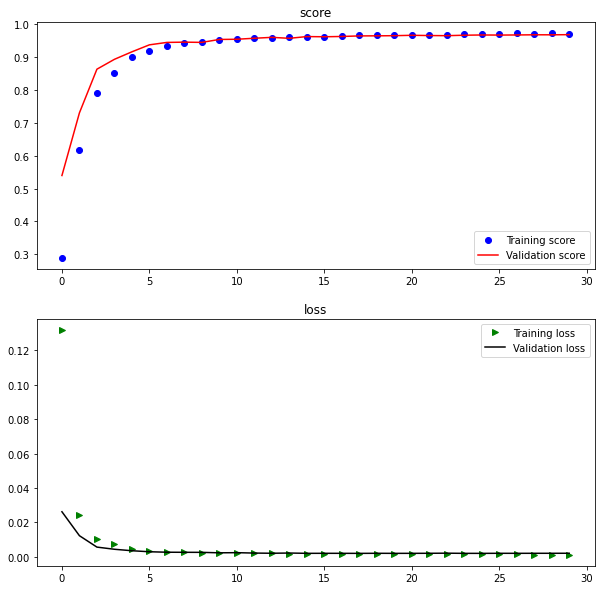

In [5]:
img_width = 320
img_height = 240
# model.save(f'new2_pupil3_{img_width}x{img_height}_{imgs_train.shape[0]}_E{EPOCHS}_B{BATCH_SIZE}_R{RANDOM_STATE}_S{round(np.mean(dice_per_fold))}.h5')
model.save(f'saved_model/new2_pupil3_{img_width}x{img_height}_{imgs_train.shape[0]}_E{EPOCHS}_B{BATCH_SIZE}_R{RANDOM_STATE}_S{round(np.mean(dice_per_fold))}')
dice_score_ = history.history['dice_score']
val_dice_score = history.history['val_dice_score']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(dice_score_))

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs, dice_score_, 'bo', label='Training score')
plt.plot(epochs, val_dice_score, 'r-', label='Validation score')
plt.title('score')
plt.legend()
plt.subplot(2,1,2)
plt.plot(epochs, loss, 'g>', label='Training loss')
plt.plot(epochs, val_loss ,'k-', label='Validation loss')
plt.title('loss')
plt.legend()
plt.show()


In [6]:
Epoch 1/15
1383/1383 - 93s - loss: 0.1201 - dice_score: 0.2952 - val_loss: 0.1303 - val_dice_score: 0.2690
Epoch 2/15
1383/1383 - 84s - loss: 0.0179 - dice_score: 0.6643 - val_loss: 0.0106 - val_dice_score: 0.7545
Epoch 3/15
1383/1383 - 84s - loss: 0.0069 - dice_score: 0.8322 - val_loss: 0.0047 - val_dice_score: 0.8860
Epoch 4/15
1383/1383 - 84s - loss: 0.0045 - dice_score: 0.8895 - val_loss: 0.0039 - val_dice_score: 0.9146
Epoch 5/15
1383/1383 - 84s - loss: 0.0032 - dice_score: 0.9245 - val_loss: 0.0035 - val_dice_score: 0.9187
Epoch 6/15
1383/1383 - 84s - loss: 0.0029 - dice_score: 0.9378 - val_loss: 0.0034 - val_dice_score: 0.9262
Epoch 7/15
1383/1383 - 84s - loss: 0.0025 - dice_score: 0.9456 - val_loss: 0.0024 - val_dice_score: 0.9526
Epoch 8/15
1383/1383 - 84s - loss: 0.0022 - dice_score: 0.9512 - val_loss: 0.0026 - val_dice_score: 0.9484
Epoch 9/15
1383/1383 - 84s - loss: 0.0021 - dice_score: 0.9567 - val_loss: 0.0022 - val_dice_score: 0.9552
Epoch 10/15
1383/1383 - 84s - loss: 0.0019 - dice_score: 0.9575 - val_loss: 0.0025 - val_dice_score: 0.9556
Epoch 11/15
1383/1383 - 84s - loss: 0.0019 - dice_score: 0.9595 - val_loss: 0.0021 - val_dice_score: 0.9603
Epoch 12/15
1383/1383 - 84s - loss: 0.0018 - dice_score: 0.9641 - val_loss: 0.0021 - val_dice_score: 0.9621
Epoch 13/15
1383/1383 - 84s - loss: 0.0017 - dice_score: 0.9661 - val_loss: 0.0021 - val_dice_score: 0.9632
Epoch 14/15
1383/1383 - 84s - loss: 0.0016 - dice_score: 0.9684 - val_loss: 0.0020 - val_dice_score: 0.9626
Epoch 15/15
1383/1383 - 84s - loss: 0.0015 - dice_score: 0.9674 - val_loss: 0.0020 - val_dice_score: 0.9643
54/54 - 10s - loss: 0.0020 - dice_score: 0.9670
        
new2_pupil3_320x240_6912_E15_B5_R3333_S9670.h5

SyntaxError: invalid syntax (3547825505.py, line 1)